In [10]:
# Install kaggle library
!pip install -q kaggle

# Upload the kaggle.json file that you downloaded from your Kaggle account
from google.colab import files
files.upload()

# Create a kaggle folder and move the json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [11]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 95% 749M/788M [00:03<00:00, 292MB/s]
100% 788M/788M [00:03<00:00, 225MB/s]


In [12]:
!unzip -q /content/microsoft-catsvsdogs-dataset.zip -d /content/

import os
import cv2
import imghdr
from pathlib import Path

data_dir = '/content/PetImages'
image_extensions = [".png", ".jpg", ".jpeg"]  # Valid extensions

img_count = 0
bad_img_count = 0

for category in os.listdir(data_dir):
    category_path = os.path.join(data_dir, category)
    if not os.path.isdir(category_path):
        continue

    for image in os.listdir(category_path):
        image_path = os.path.join(category_path, image)
        try:
            # 1. Check if the file extension is valid
            file_ext = Path(image_path).suffix.lower()
            if file_ext not in image_extensions:
                print(f"Removing invalid extension: {image_path}")
                os.remove(image_path)
                bad_img_count += 1
                continue

            # 2. Try to open and decode with OpenCV
            img = cv2.imread(image_path)
            if img is None:
                print(f"Removing unreadable image: {image_path}")
                os.remove(image_path)
                bad_img_count += 1
            else:
                img_count += 1

        except Exception as e:
            print(f"Issue with {image_path}: {e}")
            os.remove(image_path)
            bad_img_count += 1

print(f"Total valid images: {img_count}")
print(f"Total corrupted images removed: {bad_img_count}")

/tmp/ipython-input-3672390861.py:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Removing unreadable image: /content/PetImages/Cat/10404.jpg
Removing unreadable image: /content/PetImages/Cat/666.jpg
Removing invalid extension: /content/PetImages/Cat/Thumbs.db
Removing unreadable image: /content/PetImages/Dog/11702.jpg
Removing invalid extension: /content/PetImages/Dog/Thumbs.db
Total valid images: 24997
Total corrupted images removed: 5


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Setup Augmentation for Training
# We add rotation, shifts, and flips to make the model robust
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixels to [0, 1]
    rotation_range=40,        # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,    # Randomly shift horizontally
    height_shift_range=0.2,   # Randomly shift vertically
    shear_range=0.2,          # Randomly apply shearing transformations
    zoom_range=0.2,           # Randomly zoom in
    horizontal_flip=True,     # Flip images horizontally
    fill_mode='nearest',      # Fill in new pixels after a rotation or shift
    validation_split=0.2      # Set aside 20% for validation
)

# 2. Setup Generator for Validation (Only Rescaling, no Augmentation)
# We don't augment validation data because it represents "real world" testing
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [14]:
# Target size must match the input_shape in your CNN (Step 4)
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

print("Loading Training Set:")
train_generator = train_datagen.flow_from_directory(
    '/content/PetImages',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',      # Binary because we have 2 classes
    subset='training'         # Use the 80% portion
)

print("\nLoading Validation Set:")
validation_generator = validation_datagen.flow_from_directory(
    '/content/PetImages',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',      # Binary because we have 2 classes
    subset='validation'       # Use the 20% portion
)

Loading Training Set:
Found 19999 images belonging to 2 classes.

Loading Validation Set:
Found 4998 images belonging to 2 classes.


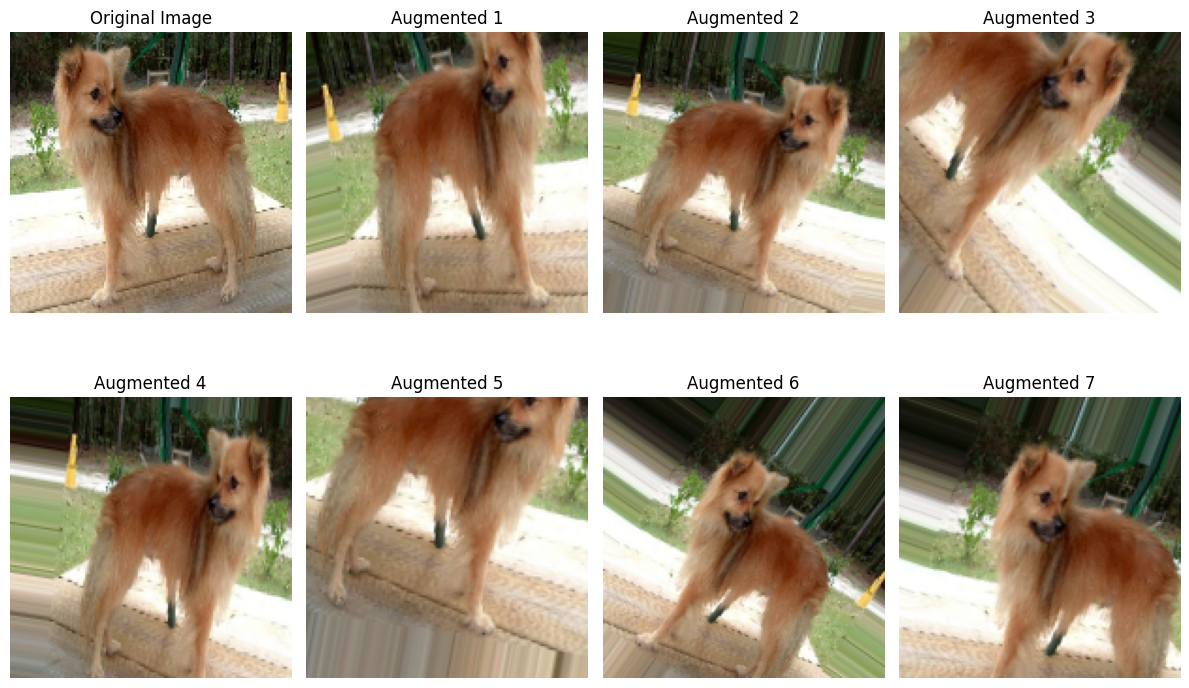

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Pick one image to test
# We'll use the first image in the 'Dog' folder
dog_files = [os.path.join('/content/PetImages/Dog', f) for f in os.listdir('/content/PetImages/Dog')]
img_path = dog_files[0]

# Load the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert to a numpy array and reshape it to (1, 150, 150, 3)
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

# Create a figure to display the images
plt.figure(figsize=(12, 8))

# 1. Show Original Image
plt.subplot(2, 4, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

# 2. Generate 7 random augmented versions
i = 2
for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(2, 4, i)
    plt.imshow(image.array_to_img(batch[0]))
    plt.title(f"Augmented {i-1}")
    plt.axis('off')

    i += 1
    if i > 8: # Stop after 7 augmentations
        break

plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import optimizers

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid') # Binary classification
])

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4), # Low learning rate for stability
    metrics=['accuracy']
)

print("Model Compiled Successfully.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Compiled Successfully.


In [17]:
import os
from PIL import Image

data_dir = '/content/PetImages'
categories = ['Cat', 'Dog']
deleted_count = 0

print("Starting deep verification of all images...")

for category in categories:
    folder_path = os.path.join(data_dir, category)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Skip directories
        if os.path.isdir(file_path):
            continue

        try:
            # This is exactly what TensorFlow tries to do during training
            with Image.open(file_path) as img:
                img.verify() # Verify the file is not corrupted
        except Exception:
            # If any error occurs (UnidentifiedImageError, etc.), delete it
            os.remove(file_path)
            deleted_count += 1

print(f"✅ Clean up finished! Removed {deleted_count} problematic files.")

Starting deep verification of all images...


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


✅ Clean up finished! Removed 0 problematic files.


In [18]:
# Re-initializing to update the image list after cleaning
train_generator = train_datagen.flow_from_directory(
    '/content/PetImages',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/PetImages',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 19999 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define paths
dataset_zip_path = '/content/microsoft-catsvsdogs-dataset.zip'
pet_images_dir = '/content/PetImages'

# Ensure the PetImages directory exists
if not os.path.exists(pet_images_dir):
    print(f"{pet_images_dir} not found. Checking for zip file...")

    # If PetImages is missing, check if the zip file needs to be downloaded
    if not os.path.exists(dataset_zip_path):
        print(f"Dataset zip file '{dataset_zip_path}' not found, attempting to download...")
        # Note: This assumes kaggle.json has been correctly uploaded and configured
        # in a previous cell (e.g., GNq_q6KvnvVy). If that cell wasn't run,
        # the kaggle download command will fail.
        !kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset
        if not os.path.exists(dataset_zip_path):
            raise FileNotFoundError(f"Failed to download {dataset_zip_path}. Please ensure kaggle.json is set up correctly and retry.")

    # Now that we ensured the zip file exists, unzip it
    print(f"Unzipping {dataset_zip_path} to {pet_images_dir}...")
    !unzip -q {dataset_zip_path} -d /content/

    if not os.path.exists(pet_images_dir):
        raise RuntimeError(f"Failed to create {pet_images_dir} after unzipping {dataset_zip_path}.")

print(f"Data directory {pet_images_dir} is ready.")

# 1. Setup Augmentation for Training (from previous cell)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# 2. Setup Generator for Validation (from previous cell)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Target size and batch size (from previous cell)
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Loading Training Set (from previous cell)
train_generator = train_datagen.flow_from_directory(
    pet_images_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# Loading Validation Set (from previous cell)
validation_generator = validation_datagen.flow_from_directory(
    pet_images_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Stop training if validation loss doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stop]
)

Data directory /content/PetImages is ready.
Found 19999 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 149s 229ms/step - accuracy: 0.5780 - loss: 0.6694 - val_accuracy: 0.6735 - val_loss: 0.5878
Epoch 2/20
  1/624 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.6250 - loss: 0.6649

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


624/624 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6250 - loss: 0.6649 - val_accuracy: 0.7121 - val_loss: 0.5591
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 138s 220ms/step - accuracy: 0.6836 - loss: 0.5852 - val_accuracy: 0.7664 - val_loss: 0.4996
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6562 - loss: 0.6454 - val_accuracy: 0.7646 - val_loss: 0.5004
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 138s 220ms/step - accuracy: 0.7089 - loss: 0.5550 - val_accuracy: 0.7724 - val_loss: 0.4885
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8750 - loss: 0.4909 - val_accuracy: 0.7720 - val_loss: 0.4878
Epoch 7/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 139s 222ms/step - accuracy: 0.7316 - loss: 0.5326 - val_accuracy: 0.7798 - val_loss: 0.4630
Epoch 8/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6562 - loss: 0.6571 - val_accuracy: 0.7851 - val_loss: 0.4616
Epoch 9/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 142s 228ms/step - accuracy: 0.7433 - loss: 0.5154 - val_acc

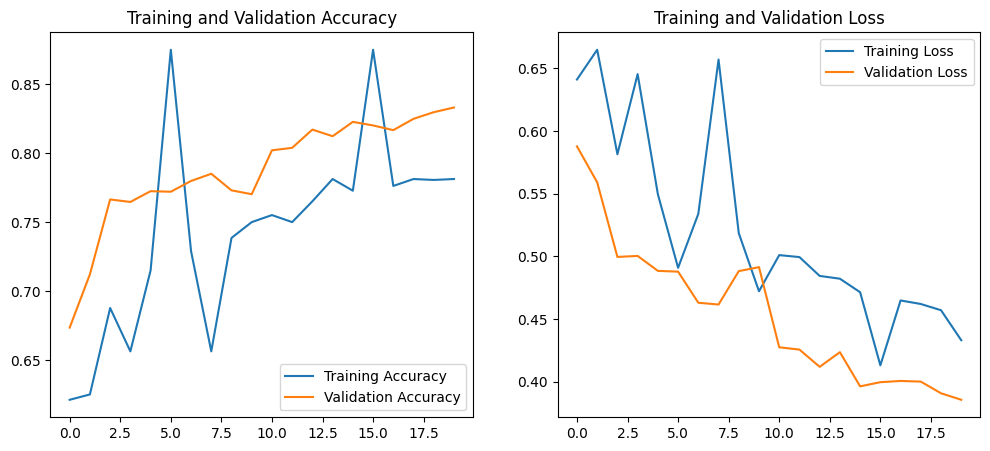

In [21]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks to make training smarter
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 141s 226ms/step - accuracy: 0.7996 - loss: 0.4324 - val_accuracy: 0.8191 - val_loss: 0.4070 - learning_rate: 1.0000e-04
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7812 - loss: 0.4306 - val_accuracy: 0.8269 - val_loss: 0.3960 - learning_rate: 1.0000e-04
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 140s 224ms/step - accuracy: 0.8032 - loss: 0.4197 - val_accuracy: 0.8353 - val_loss: 0.3581 - learning_rate: 1.0000e-04
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6875 - loss: 0.5049 - val_accuracy: 0.8435 - val_loss: 0.3517 - learning_rate: 1.0000e-04
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 141s 225ms/step - accuracy: 0.8117 - loss: 0.4103 - val_accuracy: 0.8504 - val_loss: 0.3455 - learning_rate: 1.0000e-04
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8438 - loss: 0.3685 - val_accuracy: 0.8522 - val_loss: 0.3488 - learning_rate: 1.0000e-04
Epoch 7/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 142s 227m

Saving pexels-helenalopes-2253275.jpg to pexels-helenalopes-2253275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


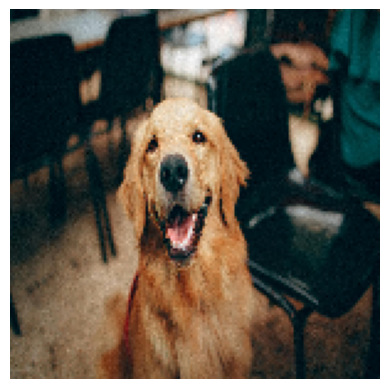

Prediction: DOG (Confidence: 96.96%)


In [24]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
    # Predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0 # Normalize the input image just like we did in training

    classes = model.predict(x)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

    if classes[0] > 0.5:
        print(f"Prediction: DOG (Confidence: {classes[0][0]*100:.2f}%)")
    else:
        print(f"Prediction: CAT (Confidence: {(1-classes[0][0])*100:.2f}%)")

In [25]:
!pip install -q gradio

In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_animal(input_img):
    # 1. Preprocess the image to match our model's requirements
    # Gradio provides the image as a numpy array
    img = input_img.copy()
    img = cv2.resize(img, (150, 150))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0) # Add batch dimension

    # 2. Make Prediction
    prediction = model.predict(img)[0][0]

    # 3. Format output
    if prediction > 0.5:
        return {"Dog": float(prediction), "Cat": float(1 - prediction)}
    else:
        return {"Dog": float(prediction), "Cat": float(1 - prediction)}

# Create the Gradio Interface
demo = gr.Interface(
    fn=predict_animal,
    inputs=gr.Image(),
    outputs=gr.Label(num_top_classes=2),
    title="🐱 Cat vs Dog Classifier 🐶",
    description="Upload an image and the CNN will tell you if it's a Cat or a Dog!",
    theme="soft", # Gives it a modern, colorful look
    examples=[os.path.join('/content/PetImages/Cat', os.listdir('/content/PetImages/Cat')[0])] # Optional example
)

# Launch the UI
demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e11c1c365b37b15886.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Created dataset file at: .gradio/flagged/dataset1.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
